In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import csv
import random
import numpy as np
from PIL import Image as PIL_Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.autograd import Variable

from torchvision import transforms
from torchvision.models import resnet50, resnet152

# 랜덤 시드 고정

In [ ]:
seed = 365

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
drivepath = "/content/gdrive/MyDrive"

In [ ]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(device)

cuda


# 모델과 그에 맞는 데이터셋 설정

Convolution layer의 출력을 FC layer에 통과시킨 뒤 매 타임스탭마다 이미지를 입력받아 키 입력을 출력하는 다대다 lstm 모델을 구성합니다.

In [ ]:
class KartModel8(nn.Module):
  def __init__(self, num_class = 64, cnn_to_lstm = 1024, lstm_hidden = 512, num_layers = 5):
    super(KartModel8, self).__init__()
    self.num_class = num_class
    self.num_layers = num_layers
    self.hidden_size = lstm_hidden

    self.resnet = resnet50(pretrained=False)
    self.resnet.fc = nn.Sequential(
      nn.Linear(in_features=2048, out_features=cnn_to_lstm, bias=True),
      nn.ReLU(),
    )
    self.lstm_image = nn.LSTM(
        input_size = cnn_to_lstm,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )
    self.lstm_key = nn.LSTM(
        input_size = 6,
        hidden_size = lstm_hidden,
        num_layers = num_layers,
        batch_first = True,
        dropout = 0.3,
    )

    self.fc_1 = nn.Linear(lstm_hidden * 2, lstm_hidden * 2)
    self.bn1 = nn.BatchNorm1d(lstm_hidden * 2)
    self.relu = nn.ReLU()
    self.fc_2 = nn.Linear(lstm_hidden * 2, lstm_hidden)
    self.bn2 = nn.BatchNorm1d(lstm_hidden)
    self.fc_3 = nn.Linear(lstm_hidden, num_class)
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x_3d, key_inputs, hidden1 = None, hidden2 = None):
    for t in range(x_3d.size(1)):
      # with torch.no_grad():
      x = self.resnet(x_3d[:, t, :, :, :])
      out1, hidden1 = self.lstm_image(x.unsqueeze(1), hidden1)
    # batch first = True
    # batch, seq, hidden_size

    out2, hidden2 = self.lstm_key(key_inputs, hidden2)

    out = self.fc_1(torch.cat([out1[:, -1, :], out2[:, -1, :]], dim=1))
    # 마지막 sequence
    out = self.bn1(out)
    out = self.relu(out)
    out = self.fc_2(out)
    out = self.bn2(out)
    out = self.relu(out)
    out = self.fc_3(out)
    # out = self.sigmoid(out)

    return out, hidden1, hidden2

In [ ]:
seq_size = 20

In [ ]:
class KartDataSet8(data.Dataset):
  def __init__(self, csv_files):
    self.image_seqs = []
    self.label_seqs = []

    for csv_file in csv_files:
      images = []
      labels = []

      with open(csv_file) as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader, None)        # 첫번째 row 스킵
        
        for row in csv_reader:
          images.append(drivepath + '/' + row[0])
          labels.append([int(x) for x in list(row[1])])

      for i in range(len(images)):
        if i - seq_size >= 0:
          self.image_seqs.append(images[i - seq_size + 1:i + 1])
          # 하나 적게
          self.label_seqs.append(labels[i - seq_size:i + 1])

  def __getitem__(self, index):
    cur_seq_size = random.randint(1, seq_size)
    image_paths = self.image_seqs[index][:cur_seq_size]
    images = [PIL_Image.open(image_path) for image_path in image_paths]
    labels = self.label_seqs[index][:cur_seq_size + 1]
    label = int(''.join(map(str, labels[-1])), 2)

    image_pads = [torch.rand(3, 224, 224) for _ in range(seq_size - cur_seq_size)]
    label_pads = [[random.randint(0, 1) for _ in range(6)] for _ in range(seq_size - cur_seq_size)]

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      # transforms.Grayscale(num_output_channels=3),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     # -1 ~ 1 로 normalize
    ])

    preprocessed_list = []
    for img in images:
      preprocessed_list.append(preprocess(img))

    # print(label_pads + labels[:-1])
    
    return torch.stack(image_pads + preprocessed_list), torch.Tensor(label_pads + labels[:-1]), label

  def __len__(self):
    return len(self.image_seqs)

In [ ]:
csvs = [f"{drivepath}/csv/kart_test_minimap_test_{str(i)}.csv" for i in range(5)]
# csvs = [f"{drivepath}/csv/kart_test_minimap2.csv"]
dataset = KartDataSet8(csvs)
# x = dataset[1]
# print(x[0].shape)
# print(x[1].shape)
print((dataset[0][0]).shape)
print((dataset[0][1]).shape)
print((dataset[99][2]))
# seq, channel, width, height
# label

torch.Size([20, 3, 224, 224])
torch.Size([20, 6])
40


# 하이퍼 파라미터 설정

In [ ]:
num_epochs = 3
lr = 1e-4
batch_size = 4
log_interval = 10

In [ ]:
loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True,
    drop_last=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(loader))
print(len(dataset))

1306
5225


# 모델 저장 설정 및 학습 가능한 레이어 확인

In [ ]:
save_path = drivepath + "/test_model_minimap3.pt"

model = KartModel8()
model.load_state_dict(torch.load(save_path))
model = model.to(device)

for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")
# model = model.to(device)

param resnet.conv1.weight  required gradient? -> True
param resnet.bn1.weight    required gradient? -> True
param resnet.bn1.bias      required gradient? -> True
param resnet.layer1.0.conv1.weight required gradient? -> True
param resnet.layer1.0.bn1.weight required gradient? -> True
param resnet.layer1.0.bn1.bias required gradient? -> True
param resnet.layer1.0.conv2.weight required gradient? -> True
param resnet.layer1.0.bn2.weight required gradient? -> True
param resnet.layer1.0.bn2.bias required gradient? -> True
param resnet.layer1.0.conv3.weight required gradient? -> True
param resnet.layer1.0.bn3.weight required gradient? -> True
param resnet.layer1.0.bn3.bias required gradient? -> True
param resnet.layer1.0.downsample.0.weight required gradient? -> True
param resnet.layer1.0.downsample.1.weight required gradient? -> True
param resnet.layer1.0.downsample.1.bias required gradient? -> True
param resnet.layer1.1.conv1.weight required gradient? -> True
param resnet.layer1.1.bn1.weigh

# Loss, Optimizer, Scheduler 설정

In [ ]:
criterion = nn.CrossEntropyLoss()
# pos_weight = torch.Tensor([5/95, 70/30, 70/30, 95/5, 85/15, 1.0])
# pos_weight = pos_weight.to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
# scheduler = StepLR(optimizer, 5, gamma=0.5)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
it = iter(loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
inputs, key_inputs, labels = next(it)
print(inputs.shape)
print(key_inputs.shape)
print(labels)
# batch, seq, channel, width, height
# batch, seq, label

torch.Size([4, 20, 3, 224, 224])
torch.Size([4, 20, 6])
tensor([32, 40, 32, 32])


# 데이터로더, 모델 인풋, 아웃풋 점검

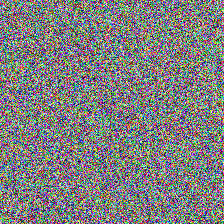

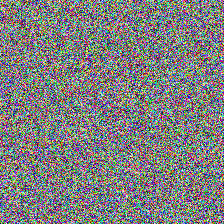

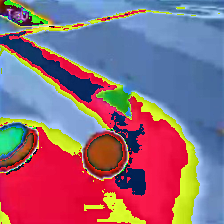

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([40, 32, 48, 40], device='cuda:0')
tensor([32, 40, 32, 32], device='cuda:0')
0
tensor(1.6763, grad_fn=<CopyBackwards>)


In [ ]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()
sigmoid = nn.Sigmoid()

display(to_img(inputs[0][0]))
display(to_img(inputs[0][1]))
display(to_img(inputs[0][-1]))

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)
outs, _, _ = model(inputs, key_inputs)
preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)
matches = (labels == preds).sum().item()
print(matches)
# print(((outs > 0.5) == labels).sum(axis=1))
# print((((outs > 0.5) == labels).sum(axis=1) == 6).sum())
loss = criterion(outs, labels)
# print(labels)
print(loss.cpu())
# print(((labels == (outs > 0.5)).sum(axis=2) == 6).sum())
# print(outs > 0.5)
# print(labels)

# 학습 진행상황 확인을 위한 wandb 설정

In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: junhyeokk (use `wandb login --relogin` to force relogin)


True

In [ ]:
config = {}
config['n_epochs'] = num_epochs
config['batch_sze'] = batch_size
# config['lr'] = lr


wandb.init(project="boomhill24_6", config=config)

# 학습 진행 및 저장

In [ ]:
for epoch in range(num_epochs):
  model.train()
  loss_value = 0
  matches = 0
  
  for idx, train_batch in enumerate(loader):
    inputs, key_inputs, labels = train_batch
    inputs = inputs.to(device)
    key_inputs = key_inputs.to(device)
    labels = labels.to(device)

    outs, _, _ = model(inputs, key_inputs)
    preds = torch.argmax(outs, dim=-1)
    loss = criterion(outs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_value += loss.item()
    # matches += (preds == labels).sum().item()
    # matches += ((preds == labels).sum(axis = 1) == 6).sum()
    matches += (labels == preds).sum().item()

    if (idx + 1) % log_interval == 0:
      train_loss = loss_value / log_interval
      train_acc = matches / batch_size / log_interval
      current_lr = scheduler.get_last_lr()

      wandb.log({"epoch" : epoch, "training_loss" : train_loss, "training_acc" : train_acc, "learning_rate" : current_lr})
      print(
          f"Epoch[{epoch + 1}/{num_epochs}]({idx + 1}/{len(loader)}) || "
          # f"training loss {train_loss:4.4} || lr {current_lr}"
          f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      loss_value = 0
      matches = 0

    scheduler.step()
    
  # torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[1/3](10/1306) || training loss 2.173 || training accuracy 37.50% || lr [9.221639627510075e-05]
Epoch[1/3](20/1306) || training loss 1.81 || training accuracy 35.00% || lr [6.840622763423389e-05]
Epoch[1/3](30/1306) || training loss 1.871 || training accuracy 32.50% || lr [3.756550564175724e-05]
Epoch[1/3](40/1306) || training loss 1.892 || training accuracy 25.00% || lr [1.1474337861210536e-05]
Epoch[1/3](50/1306) || training loss 2.138 || training accuracy 25.00% || lr [9.866357858642197e-08]
Epoch[1/3](60/1306) || training loss 1.975 || training accuracy 27.50% || lr [7.78360372489924e-06]
Epoch[1/3](70/1306) || training loss 2.264 || training accuracy 20.00% || lr [3.15937723657661e-05]
Epoch[1/3](80/1306) || training loss 2.309 || training accuracy 20.00% || lr [6.243449435824273e-05]
Epoch[1/3](90/1306) || training loss 1.987 || training accuracy 22.50% || lr [8.852566213878945e-05]
Epoch[1/3](100/1306) || training loss 2.261 || training accuracy 20.00% || lr [9.990133642141

In [ ]:
torch.save(model.state_dict(), save_path)

torch.Size([4, 20, 3, 224, 224])
torch.Size([4, 20, 6])
torch.Size([4])


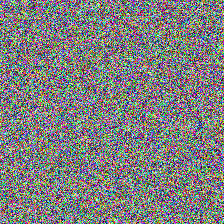

tensor([[-0.3735, -7.6942, -4.0846, -7.7438, -7.7115, -7.7769, -7.6786, -7.7670,
         -1.3126, -7.7263, -5.2136, -5.0428, -7.7230, -7.6958, -7.7224, -7.6936,
         -3.8697, -7.5412, -3.9419, -7.7153, -7.7153, -7.6885, -7.7247, -7.7429,
         -7.7144, -7.6940, -7.6913, -7.7541, -7.7043, -7.7020, -7.7419, -7.7156,
          1.2909, -7.7124, -3.2128, -7.7039, -2.1439, -7.7280, -7.6821, -7.7245,
          2.4662, -7.7446,  1.3950, -7.7192, -0.1749, -7.6821, -0.4651, -7.7619,
          0.3128, -7.7075, -2.5942, -7.7178, -2.5844, -7.7409, -3.9061, -7.7274,
         -3.3863, -7.7732, -1.6839, -7.7025, -7.7133, -7.7131, -5.8105, -7.6776],
        [-2.1078, -6.5019, -5.9061, -6.3860, -6.3474, -6.4588, -6.3715, -6.4164,
         -3.6891, -6.4011, -6.3725, -5.6719, -6.4211, -6.3730, -6.4125, -6.3699,
         -3.0744, -6.5666, -4.7148, -6.3496, -6.3961, -6.4136, -6.3848, -6.4008,
         -6.3780, -6.3885, -6.3695, -6.3867, -6.3986, -6.3794, -6.3766, -6.4033,
          1.2864, -6.4194, 

In [ ]:
inputs, key_inputs, labels = next(it)
print(inputs.shape)
print(key_inputs.shape)
print(labels.shape)
# batch, seq, channel, width, height
# batch, seq, label

display(to_img(inputs[0][0]))
# display(to_img(inputs[0][1]))
# display(to_img(inputs[0][-1]))

model.eval()

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)
outs, h1, h2 = model(inputs, key_inputs)
print(outs)
preds = torch.argmax(outs, dim=-1)
print(preds)
loss = criterion(outs, labels)
print(labels)
print(loss.cpu())

In [ ]:
print(labels)

tensor([32, 50, 40, 52], device='cuda:0')


In [ ]:
torch.cuda.empty_cache()

inputs, key_inputs, labels = next(it)

model.eval()

inputs = inputs.to(device)
key_inputs = key_inputs.to(device)
labels = labels.to(device)

outs, h1, h2 = model(inputs, key_inputs)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

RuntimeError: ignored

In [ ]:
model.eval()

outs, _, _ = model(inputs, key_inputs, h1, h2)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

In [ ]:
model.eval()

outs, _, _ = model(inputs, key_inputs)

preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)

In [ ]:
model.eval()

h1 = None
h2 = None

idx = 350
for i in range(seq_size):
  img = dataset[idx][0][i].unsqueeze(0).unsqueeze(0).to(device)
  key = dataset[idx][1][i].unsqueeze(0).unsqueeze(0).to(device)
  out, h1, h2 = model(img, key, h1, h2)
  pred = torch.argmax(out, dim=-1)
  print(pred.item())
print(f"label : {dataset[idx][2]}")